In [4]:
import torch as t
import w1d4_tests
import matplotlib.pyplot as plt

In [5]:
fname = "/home/ubuntu/mlab/days/w1d4/raichu.png"

In [6]:
%pwd

'/home/ubuntu/mlab/days/w1d4'

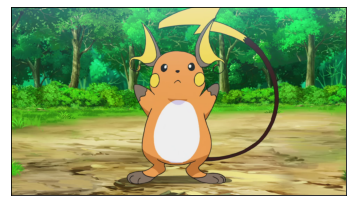

In [7]:
import w1d4_tests
w1d4_tests.plot_image(fname)

In [8]:
data_train, data_test =  w1d4_tests.load_image(fname)

from PIL import Image
img = Image.open(fname)
from torchvision import transforms
tensorize = transforms.ToTensor()
img = tensorize(img)

In [129]:
import gin
gin.enter_interactive_mode()

In [118]:
@gin.configurable
class RaichuModel(t.nn.Module):
    def __init__(self, P, H, K):
        super().__init__()
        self.layers = t.nn.Sequential(t.nn.Linear(P, H), 
            t.nn.ReLU(),
            t.nn.Linear(H, H),
            t.nn.ReLU(),
            t.nn.Linear(H, K),
        )

    def forward(self, x):
        return self.layers(x)

In [115]:
w1d4_tests.test_mlp(RaichuModel)

Congrats! You've passed the test.


In [124]:
@gin.configurable
def train(model, dataloader, lr, momentum=0.9, optimizer_kind='SGD'): # -> trained model
    if optimizer_kind == 'SGD':
        optimizer = t.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_kind == 'RMSprop':
        optimizer = t.optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_kind == 'Adam':
        optimizer = t.optim.Adam(model.parameters(), lr=lr)

    for X, Y in dataloader:
        optimizer.zero_grad()
        output = model(X)
        loss = t.nn.functional.l1_loss(output, Y)
        loss.backward()
        optimizer.step()

    return model

w1d4_tests.test_train(train)

Congrats! You've passed the test.


In [125]:
def evaluate(model, dataloader):
    cumulative_loss = 0
    for X, Y in dataloader:
        loss = t.nn.functional.l1_loss(model(X), Y)
        cumulative_loss += loss.detach()
    return cumulative_loss / len(dataloader)

w1d4_tests.test_evaluate(evaluate)

Congrats! You've passed the test.


In [141]:
model = RaichuModel(2, 400, 3)
@gin.configurable
def trains(model, data_train, data_test, num_epochs):
    results = []
    for _ in range(num_epochs):
        train(model, data_train)
        train_quality = evaluate(model, data_train)
        test_quality = evaluate(model, data_test)
        results.append((train_quality, test_quality))

    return results

def plot_qualities():
    qualities = trains(model, data_train, data_test)
    train_qualities = list(map(lambda x: x[0], qualities))
    test_qualities = list(map(lambda x: x[1], qualities))
    plt.scatter(list(range(len(train_qualities))), train_qualities, label="train loss")
    plt.scatter(list(range(len(test_qualities))), test_qualities, label="test loss")
    plt.legend()


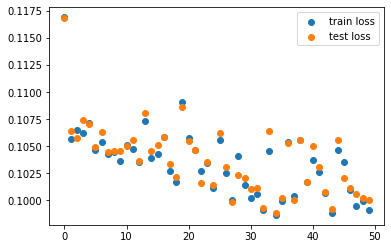

In [144]:
with gin.unlock_config():
    gin.parse_config_file('config.gin')
    plot_qualities()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


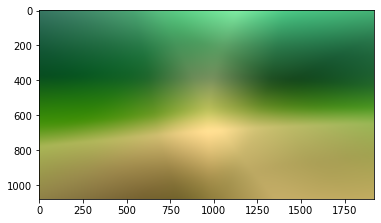

In [15]:
def show_my_image(img, model):
    img_depth, img_height, img_width = img.shape
    result = t.zeros(img.shape)

    height_indices = t.arange(img_height, dtype=t.float)
    height_indices /= img_height
    height_indices -= 0.5

    width_indices = t.arange(img_width, dtype=t.float)
    width_indices /= img_width
    width_indices -= 0.5

    indices = t.stack((
        height_indices.unsqueeze(1).expand(img_height, img_width),
        width_indices.unsqueeze(0).expand(img_height, img_width)
        ), 2
    )
    result = model(indices).detach()
    result += 0.5
    plt.imshow(result)

show_my_image(img, model)

In [16]:
def f(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2 + 1

def plot_f(path):
    import numpy as np
    xs = t.arange(400) / 100 - 2
    ys = t.arange(400) / 100 - 1
    zs = [[np.log(f(x / 100.0, y / 100.0)) for x in range(-200, 200)] for y in range(-100, 300)]
    plt.contourf(xs, ys, zs)
    plt.scatter(path[:,0], path[:,1], c='r')

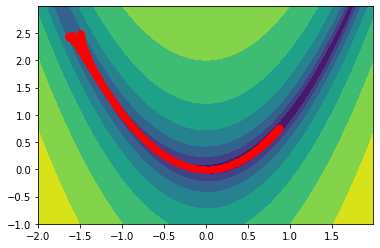

In [17]:
def opt_rosenbrock(xy, lr, momentum, n_iter):
    optimizer = t.optim.SGD([xy], lr=lr, momentum=momentum)
    result = t.zeros(n_iter + 1, 2)
    result[0,:] = xy.detach()
    for i in range(1, n_iter + 1):
        optimizer.zero_grad()
        loss = f(xy[0], xy[1])
        loss.backward()
        optimizer.step()
        result[i,:] = xy.detach()
    return result

path = opt_rosenbrock(t.tensor([-1.5, 2.5], requires_grad=True), lr=1e-3, momentum=0.9, n_iter=400)
plot_f(path)

In [18]:
class SGD:
    def __init__(self, params, lr, momentum=0, dampening=0, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.dampening = dampening
        self.weight_decay = weight_decay
        self.last_gs = [None for i in range(len(self.params))]

    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self):
        with t.no_grad():
            for i, param in enumerate(self.params):
                g = param.grad
                g += self.weight_decay * param
                if self.last_gs[i] is not None:
                    g = (1.0 - self.dampening) * g
                    g += self.momentum * self.last_gs[i]
                self.last_gs[i] = g 
                param -= g * self.lr

w1d4_tests.test_sgd(SGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'dampening': 0.0, 'weight_decay': 0.05}
Congrats! You've passed the test.


In [44]:

class RMSProp:
    def __init__(
        self, params, lr=0.01, alpha=0.99, eps=1e-8, weight_decay=0.,
            momentum=0.):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.wd = weight_decay
        self.mu = momentum

        self.v = [t.zeros_like(p) for p in self.params]
        self.b = [t.zeros_like(p) for p in self.params]
        self.g_ave = [t.zeros_like(p) for p in self.params]

    def zero_grad(self):
        for p in self.params:
            p.grad = None

    def step(self):
        with t.no_grad():
            for i, p in enumerate(self.params):
                assert p.grad is not None
                g = p.grad + self.wd * p
                self.v[i] = self.alpha * self.v[i] + (1.0 - self.alpha) * g ** 2
                if self.mu:
                    self.b[i] = self.mu * self.b[i] + g / (self.v[i].sqrt() + self.eps)
                    p -= self.lr * self.b[i]
                else:
                    p -= self.lr * g / (self.v[i].sqrt() + self.eps)

In [37]:
%python3 

UsageError: Line magic function `%python3` not found (But cell magic `%%python3` exists, did you mean that instead?).


In [38]:
class Adam:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.first_moment = [0.0 for param in self.params]
        self.second_moment = [0.0 for param in self.params]
        self.t = 0

    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self):
        with t.no_grad():
            self.t += 1
            for i, param in enumerate(self.params):
                g = param.grad
                g += self.weight_decay * param
                b1, b2 = self.betas
                self.first_moment[i] *= b1
                self.first_moment[i] += (1 - b1)*g
                self.second_moment[i] *= b2
                self.second_moment[i] += (1 - b2)*g**2
                m_hat = self.first_moment[i] / (1 - b1**self.t)
                v_hat = self.second_moment[i] / (1 - b2**self.t)
                param -= self.lr * m_hat/(v_hat**0.5 + self.eps)

w1d4_tests.test_adam(Adam)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
Congrats! You've passed the test.


In [39]:
def opt_rosenbrock(optimizer, xy, tolerance=0.1, max_tries=4000):
    optimum = t.tensor([1.0, 1.0])
    for i in range(max_tries):
        optimizer.zero_grad()
        loss = f(xy[0], xy[1])
        if t.linalg.norm(xy - optimum) < tolerance:
            break
        loss.backward()
        optimizer.step()
    return i



In [40]:
initial_xy = t.tensor([-1.5, 2.5], requires_grad=True)
opt_rosenbrock(
    optimizer = SGD([initial_xy], lr=1e-3, momentum=0.9, weight_decay=0.0),
    xy=initial_xy,
)



619

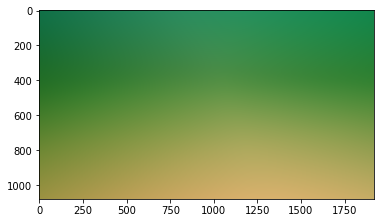

In [45]:
def train(model, dataloader, lr, momentum=0.9): # -> trained model
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)

    for X, Y in dataloader:
        optimizer.zero_grad()
        output = model(X)
        loss = t.nn.functional.l1_loss(output, Y)
        loss.backward()
        optimizer.step()

    return model

model = RaichuModel(2, 400, 3)
model = train(model, data_train, 0.03)
show_my_image(img, model)

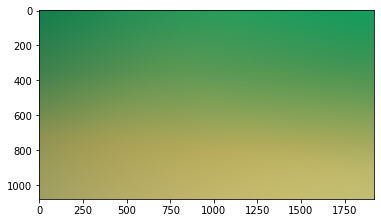

In [46]:
def train(optimizer, model, dataloader, lr, momentum=0.9): # -> trained model
    # optimizer = RMSProp(model.parameters(), lr=lr, momentum=momentum)

    for X, Y in dataloader:
        optimizer.zero_grad()
        output = model(X)
        loss = t.nn.functional.l1_loss(output, Y)
        loss.backward()
        optimizer.step()

    return model

model = RaichuModel(2, 400, 3)
model = train(RMSProp(model.parameters()), model, data_train, 0.03)
show_my_image(img, model)

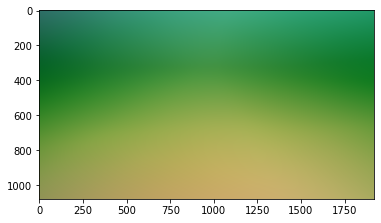

In [47]:
def train(optimizer, model, dataloader, lr, momentum=0.9): # -> trained model
    # optimizer = RMSProp(model.parameters(), lr=lr, momentum=momentum)

    for X, Y in dataloader:
        optimizer.zero_grad()
        output = model(X)
        loss = t.nn.functional.l1_loss(output, Y)
        loss.backward()
        optimizer.step()

    return model

model = RaichuModel(2, 400, 3)
model = train(Adam(model.parameters()), model, data_train, 0.03)
show_my_image(img, model)

In [33]:
initial_xy = t.tensor([-1.5, 2.5], requires_grad=True)
opt_rosenbrock(
    optimizer = RMSProp([initial_xy], lr=1e-2, alpha=0.9, eps=1e-8, weight_decay=0.0, momentum=0.9),
    xy=initial_xy,
)

NameError: name 'RMSProp' is not defined

In [ ]:
initial_xy = t.tensor([-1.5, 2.5], requires_grad=True)
opt_rosenbrock(
    optimizer = Adam([initial_xy], lr=0.1, betas=(0.8, 0.95), eps=0.001),
    xy=initial_xy,
)

323